# Example: Obsid 18983 - prior to BSH 2017/090 #

In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from Quaternion import Quat
from astropy.table import Table
import Ska.Numpy
from Ska.engarchive import fetch_sci as fetch
from mica.archive import asp_l1
from mica.archive.aca_l0 import get_l0_images, get_slot_data
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime
import cxotime
from chandra_aca.aca_image import ACAImage
import chandra_aca.transform as transform
from Ska.quatutil import yagzag2radec, radec2yagzag
from kadi import events
import mica.starcheck

In [ ]:
# local imports:
import sys
sys.path.append(".")
import aca_simulate as sim
reload(sim)
from aca_simulate import ImgList

In [3]:
def get_telem(cat, slot):
    ok = (cat['slot'] == slot) * ((cat['type'] == 'BOT') + (cat['type'] == 'GUI'))
    yag, zag = cat['yang'][ok][0], cat['zang'][ok][0]
    mag, maxmag = cat['mag'][ok][0], cat['maxmag'][ok][0]
    return yag, zag, mag, maxmag


def as_array(attr, imgs):
    out = np.array([getattr(img, attr) for img in imgs])
    return out


def plot_star(star, c32=True, cbar=True):
    plt.imshow(star, interpolation='none', cmap='hot', vmin = -100, vmax=2300, origin='lower')
    if cbar:
        plt.colorbar()
    plt.hlines(np.arange(0.5, 7.5), -0.5, 7.5, colors='y', linestyles='dotted')
    plt.vlines(np.arange(0.5, 7.5), -0.5, 7.5, colors='y', linestyles='dotted')
    if c32:
        c32 = np.array([1, 2, 2, 6, 6, 7, 7, 6, 6, 2, 2, 1, 1]) - 0.5
        r32 = np.array([2, 2, 1, 1, 2, 2, 6, 6, 7, 7, 6, 6, 2]) - 0.5
        if star.shape == (6, 6):
            r32 = r32 - 1
            c32 = c32 - 1
        plt.plot(c32, r32, '-', lw=2, color='w')
    plt.xlim(-0.5, 7.5)
    plt.ylim(-0.5, 7.5)
    plt.ylabel('Row')
    plt.xlabel('Column')
    plt.title('(ROW0, COL0) = ({:.0f}, {:.0f})'.format(row0, col0))
    return


def plot_set(imgs, start, vmin=-10, vmax=2000, num=4, grid6x6=False):
    for i in np.arange(start, start + num):
        plt.subplot(1, num, i - start + 1)
        plt.imshow(imgs[i], interpolation='none', origin='lower',
                   cmap='hot', vmin=vmin, vmax=vmax)
        if grid6x6:
            plt.hlines(np.arange(0.5, 5.5), -0.5, 5.5, colors='y', linestyles='dotted')
            plt.vlines(np.arange(0.5, 5.5), -0.5, 5.5, colors='y', linestyles='dotted')
        plt.xlabel('Column (px)')
        plt.ylabel('Row (px)')
    return


def centroids(img):
    if img.shape == (8, 8):
        img = img[ACAImage(row0=img.row0 + 1, col0=img.col0 + 1, shape=(6, 6))]
    rw, cw = np.mgrid[0:6, 0:6] + 0.5
    img[[0, 0, 5, 5], [0, 5, 0, 5]] = 0.
    norm = np.sum(img)
    r = np.sum(rw * img) / norm
    c = np.sum(cw * img) / norm
    return np.float(r), np.float(c)


class ObcAca(object):
    def __init__(self, start, stop, slot):
        self.yags = fetch.Msid('aoacyan{}'.format(slot), start, stop)
        self.zags = fetch.Msid('aoaczan{}'.format(slot), start, stop)
        self.funcs = fetch.Msid('aoacfct{}'.format(slot), start, stop)
        self.seqs = fetch.Msid('aoacaseq'.format(slot), start, stop)
        self.mags = fetch.Msid('aoacmag{}'.format(slot), start, stop)
        self.defpix = fetch.Msid('aoacidp{}'.format(slot), start, stop)
        self.multstars = fetch.Msid('aoacims{}'.format(slot), start, stop)
        self.t_aca = fetch.Msid('aach1t', start, stop)
        self.t_aca = np.mean(self.t_aca.vals)
        self.ok = (self.yags.vals > -3200) & (self.zags.vals > -3200)
        self.imgs = get_l0_images(start, stop, slot=slot,
                                   columns=['IMGROW0', 'IMGCOL0', 'BGDAVG', 'TIME'])
        self.row0s = as_array('IMGROW0', self.imgs)
        self.col0s = as_array('IMGCOL0', self.imgs)
        self.bgdavgs = as_array('BGDAVG', self.imgs)
        self.times = as_array('TIME', self.imgs)
        
    def __getattr__(imgs, attr):
        return np.array([getattr(img, attr) for img in imgs])
    

def plot_true_yags_zags(nstop, times, true_yags, true_zags, obc_yags, obc_zags):
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plot_cxctime(times[:nstop], true_yags[:nstop], 'b', alpha=0.3, lw=5)
    plot_cxctime(times[:nstop], obc_yags[:nstop], 'k', lw=1.5)
    plt.ylabel('True yags')
    plt.xlabel('Time')
    plt.ylim(obc_yags[0] - 20, obc_yags[0] + 20);
    plt.subplot(1, 2, 2)
    plot_cxctime(times[:nstop], true_zags[:nstop], 'b', alpha=0.3, lw=5, label='True')
    plot_cxctime(times[:nstop], obc_zags[:nstop], 'k', label='OBC', lw=1.5)
    plt.ylabel('True zags');
    plt.xlabel('Time')
    plt.ylim(obc_zags[0] - 40, obc_zags[0] + 40)
    plt.legend();
    return


def get_true_yags_zags(n, yag, zag, quat):
    true_yags = np.zeros(n)
    true_zags = np.zeros(n)
    quats = [quat]
    true_yags[0] = yag
    true_zags[0] = zag
    ra, dec = yagzag2radec(yag / 3600., zag / 3600., quat) # pointing, not the star

    for ii in range(1, n):
        dyaw, dpitch = yaw[ii] - yaw[0], pitch[ii] - pitch[0]
        dq = Quat([dyaw / 3600., -dpitch / 3600., 0.])
        quats.append(quat * dq)
        y, z = radec2yagzag(ra, dec, quats[-1])
        true_yags[ii] = y * 3600.
        true_zags[ii] = z * 3600.

    return true_yags, true_zags


def plot_guide_summary(guide):
    plt.figure(figsize=(13, 26))

    xlim = len(guide['time']) * 2.05
    
    plt.subplot(6, 1, 1)

    plt.plot(guide['time'] - guide['time'][0], guide['true_yags'], 'b', lw=5, alpha=0.5, label='true')
    plt.plot(obc.yags.times[1::2] - obc.yags.times[1], obc.yags.vals[1::2], 'k', label='OBC')
    plt.plot(guide['time'] - guide['time'][0], guide['aca_yags'], 'c', lw=5, alpha=0.5, label='sim')
    plt.legend()
    plt.ylabel('Yags')
    plt.xlim(0, xlim)
    plt.ylim(yag - 40, yag + 40);

    plt.subplot(6, 1, 2)

    plt.plot(obc.times - obc.times[0], obc.row0s, 'k', label='OBC')
    plt.plot(guide['time'] - guide['time'][0], guide['row0s'], 'c', lw=5, alpha=0.5, label='sim')
    plt.legend()
    plt.ylabel('ROW0')
    plt.xlim(0, xlim)
    plt.ylim(obc.row0s[0] - 10, obc.row0s[0] + 10)
    plt.margins(0.05);

    plt.subplot(6, 1, 3)

    plt.plot(guide['time'] - guide['time'][0], guide['true_zags'] + pitch[0], 'b', lw=5, alpha=0.5)
    plt.plot(obc.zags.times[1::2] - obc.zags.times[1], obc.zags.vals[1::2], 'k')
    plt.plot(guide['time'] - guide['time'][0], guide['aca_zags'], 'c', lw=5, alpha=0.5)
    plt.ylabel('Zags')
    plt.xlim(0, xlim)
    plt.ylim(zag - 40, zag + 40);

    plt.subplot(6, 1, 4)

    plt.plot(obc.times - obc.times[0], obc.col0s, 'k', label='OBC')
    plt.plot(guide['time'] - guide['time'][0], guide['col0s'], 'c', lw=5, alpha=0.5, label='sim')
    plt.legend()
    plt.ylabel('COL0')
    plt.xlim(0, xlim)
    plt.ylim(obc.col0s[0] - 10, obc.col0s[0] + 10)
    plt.margins(0.05);

    plt.subplot(6, 1, 5)

    plt.plot(obc.times - obc.times[0], obc.bgdavgs, 'k', label='OBC')
    plt.plot(guide['time'] - guide['time'][0], guide['bgdavgs'], 'c', lw=5, alpha=0.5, label='sim')
    plt.ylabel('BGDAVG')
    plt.legend()
    plt.xlim(0, xlim)
    plt.ylim(0, 100);

    plt.subplot(6, 1, 6)

    plt.plot(obc.mags.times - obc.mags.times[0], obc.mags.vals, 'k', label='OBC')
    plt.plot(guide['time'] - guide['time'][0], guide['aca_mags'], 'c', lw=5, alpha=0.5, label='sim')
    plt.ylabel('MAGS')
    plt.legend()
    plt.xlim(0, xlim)
    plt.ylim(mag - 1.0, mag + 1.0);
    
    return

## Obsid 18983 ##

In [4]:
obsid = 18983
d = events.dwells.filter(obsid=obsid)[0]
sc = mica.starcheck.get_starcheck_catalog_at_date(d.start)

In [5]:
quat_cat = Quat([sc['manvr']['target_Q{}'.format(i)][0] for i in (1, 2, 3, 4)])
cat = sc['cat']
obs = sc['obs']
dither = {'dither_y_amp': obs['dither_y_amp'], 'dither_z_amp': obs['dither_z_amp'],
          'dither_y_period': obs['dither_y_period'], 'dither_z_period': obs['dither_z_period'],
          'dither_y_phase': 0., 'dither_z_phase': 0.}

if np.any([dither[key] == None for key in dither.keys()]):
    dither = {'dither_y_amp': 8., 'dither_z_amp': 8.,
              'dither_y_period': 1000., 'dither_z_period': 707.1,
              'dither_y_phase': 0., 'dither_z_phase': 0.}

In [6]:
atts = fetch.MSIDset(['aoattqt*'], d.start, d.stop)
quat_obc = Quat([atts['aoattqt{}'.format(i + 1)].vals[0] for i in range(4)])

In [7]:
print(quat_cat)
print(quat_obc)

<Quat q1=0.49947489 q2=-0.33350427 q3=-0.75701845 q4=0.25733791>
<Quat q1=0.49949571 q2=-0.33350016 q3=-0.75700218 q4=0.25735068>


## Slot 3. Tracking a bright star ##

In [8]:
slot = 3
yag_cat, zag_cat, mag, maxmag = get_telem(cat, slot)
print('Slot {}, guiding on star with:'.format(slot))
print('yag_cat = {:.0f}, zag_cat = {:.0f}, mag = {:.3f}, maxmag = {:.3f}'.format(yag_cat, zag_cat, mag, maxmag))

Slot 3, guiding on star with:
yag_cat = -41, zag_cat = 1469, mag = 7.230, maxmag = 8.734


In [9]:
obc = ObcAca(d.start, d.stop, slot=slot)

In [10]:
obc.yags.vals[:10], obc.yags.vals[0::2][:5]

(array([-42.875, -42.9  , -42.9  , -43.   , -43.   , -43.1  , -43.1  ,
        -43.15 , -43.15 , -43.175]),
 array([-42.875, -42.9  , -43.   , -43.1  , -43.15 ]))

In [11]:
yag_cat - obc.yags.vals[0], zag_cat - obc.zags.vals[0], 'px'

(1.875, -14.150000000000091, 'px')

In [12]:
reload(sim)
dither['dither_y_phase'] = 0.05 # fraction of 2pi
dither['dither_z_phase'] = -0.14
yaw = sim.calc_dither(obc.yags.times[0::2], dither, 'y')
pitch = sim.calc_dither(obc.yags.times[0::2], dither, 'z')

yaw[0], pitch[0], 'arcsec'

(4.3950260254519993, 3.3400043314827634, 'arcsec')

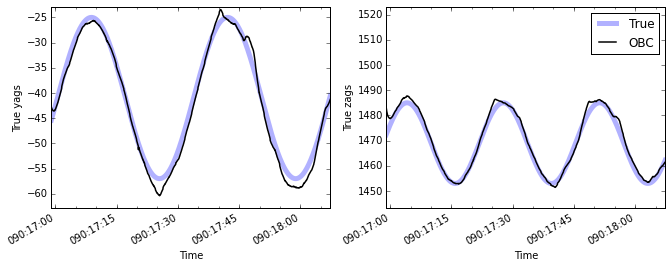

In [13]:
nstop = 2000
n = len(obc.yags.times[0::2][:nstop])
true_yags, true_zags = get_true_yags_zags(n, yag_cat, zag_cat, quat_cat)

plot_true_yags_zags(nstop, obc.yags.times[0::2],
                    true_yags - yaw[0], true_zags + pitch[0],
                    obc.yags.vals[0::2], obc.zags.vals[0::2])

In [ ]:
reload(sim)
kwargs = {'radius': 40., 'imgsize': 6, 'dither': dither, 'dark': '2017:092'}
yag = yag_cat - yaw[0]
zag = zag_cat + pitch[0]

dq = Quat([yaw[0] / 3600., -pitch[0] / 3600., 0.])
quat = quat_cat * dq

guide = sim.simulate_guide(obc.yags.times[0::2][:1000], quat, yag, zag, mag, **kwargs)

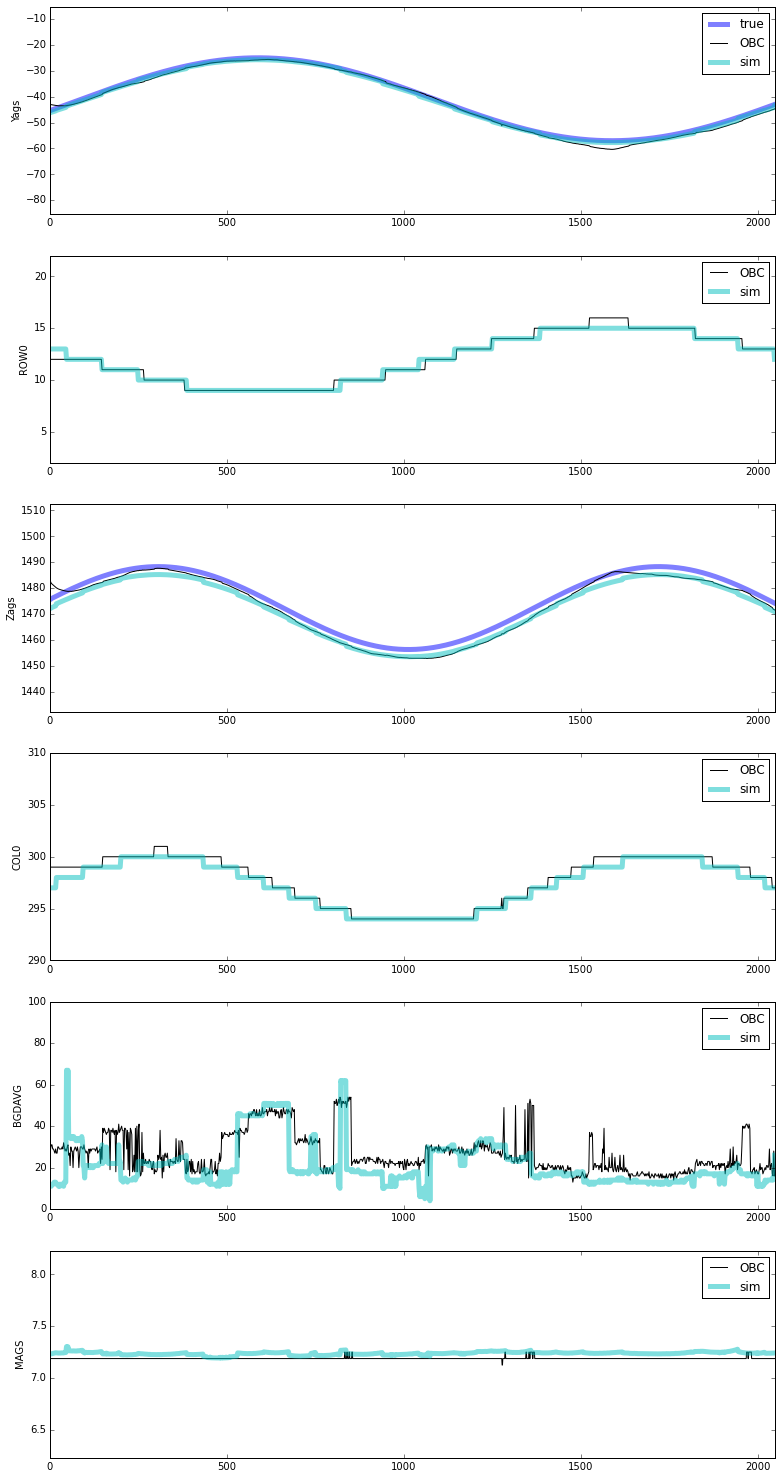

In [15]:
plot_guide_summary(guide)

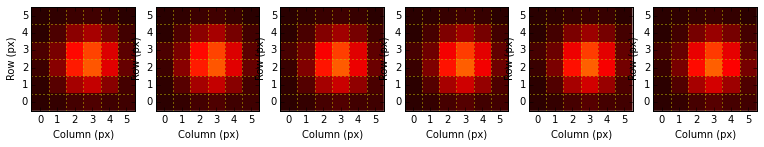

In [16]:
plt.figure(figsize=(13, 5))
start, num = 0, 6
plot_set(guide['imgraws'], start=start, num=num, vmin=-300, vmax=7000, grid6x6=True)

## Slot 6. Tracking a hot pixel ##

In [17]:
slot = 6
yag_cat, zag_cat, mag, maxmag = get_telem(cat, slot)
print('Slot {}, guiding on star with:'.format(slot))
print('yag = {:.0f}, zag = {:.0f}, mag = {:.3f}, maxmag = {:.3f}'.format(yag_cat, zag_cat, mag, maxmag))

Slot 6, guiding on star with:
yag = -164, zag = -1661, mag = 9.772, maxmag = 11.828


In [18]:
obc = ObcAca(d.start, d.stop, slot=slot)

In [19]:
obc.yags.vals[:10], obc.yags.vals[0::2][:5]

(array([-166.95 , -166.975, -166.975, -167.05 , -167.05 , -167.2  ,
        -167.2  , -167.3  , -167.3  , -167.2  ]),
 array([-166.95 , -166.975, -167.05 , -167.2  , -167.3  ]))

In [20]:
yag_cat - obc.yags.vals[0], zag_cat - obc.zags.vals[0], 'px'

(2.9500000000000171, -11.549999999999955, 'px')

In [21]:
reload(sim)
# Dither phase - same as for the bright star in slot 3
yaw = sim.calc_dither(obc.yags.times[0::2], dither, 'y')
pitch = sim.calc_dither(obc.yags.times[0::2], dither, 'z')
  
yaw[0], pitch[0], 'arcsec'

(4.3950260254519993, 3.3400043314827634, 'arcsec')

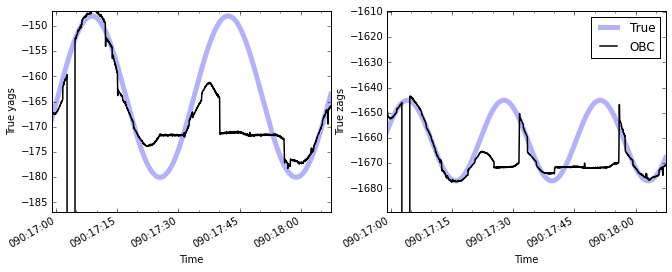

In [22]:
nstop = 2000
n = len(obc.yags.times[0::2][:nstop])
true_yags, true_zags = get_true_yags_zags(n, yag_cat, zag_cat, quat_cat)

plot_true_yags_zags(nstop, obc.yags.times[0::2],
                    true_yags - yaw[0], true_zags + pitch[0],
                    obc.yags.vals[0::2], obc.zags.vals[0::2])

In [23]:
reload(sim)
kwargs = {'radius': 40., 'imgsize': 6, 'dither': dither, 'dark': '2017:100'}
yag = yag_cat - yaw[0]
zag = zag_cat + pitch[0]
guide = sim.simulate_guide(obc.yags.times[0::2][0:1000], quat, yag, zag, mag, **kwargs)

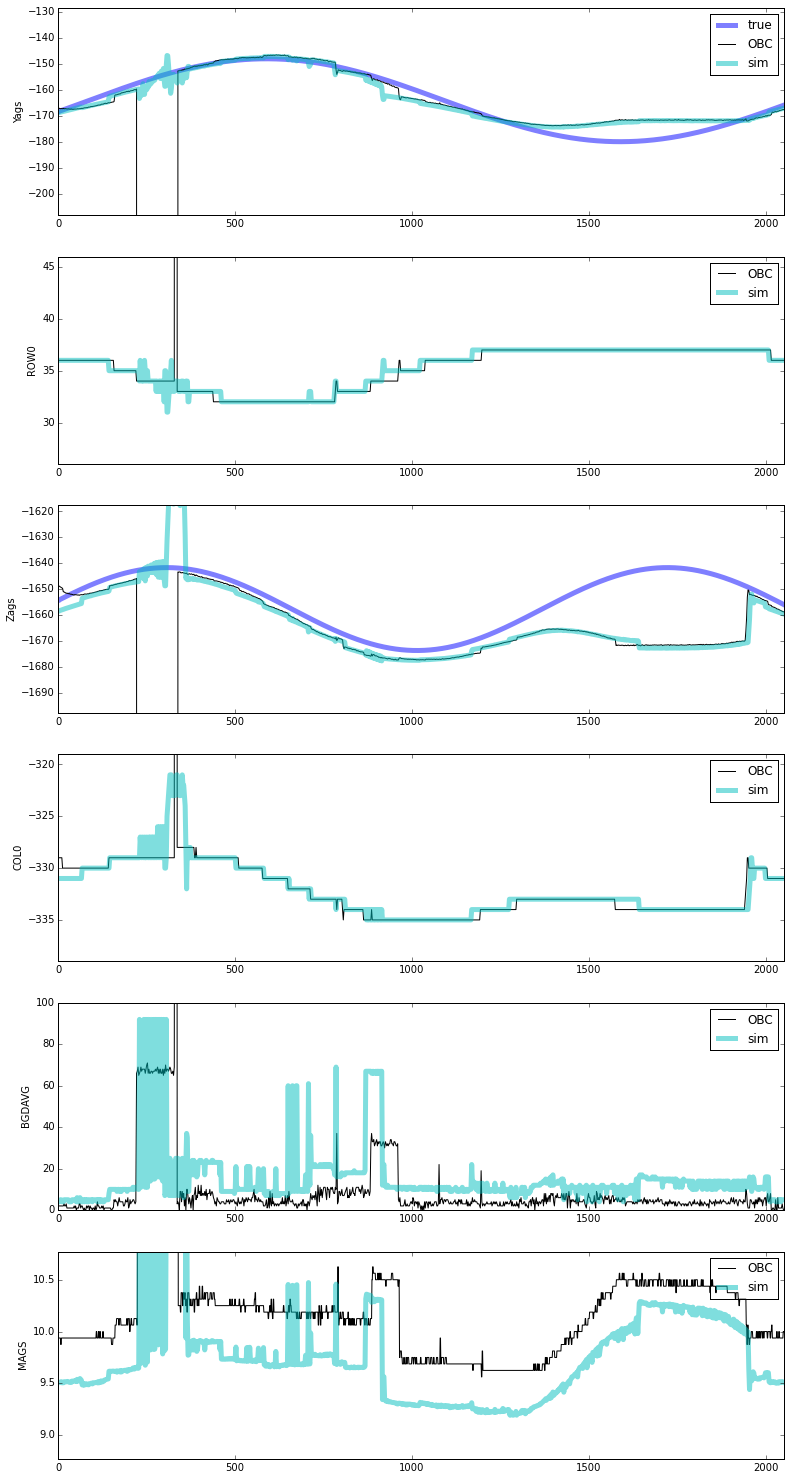

In [24]:
plot_guide_summary(guide)

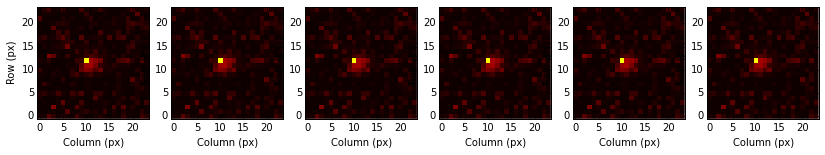

In [25]:
plt.figure(figsize=(14, 5))
start, num = 600, 6
plot_set(guide['stars'], start=start, num=num, vmax=1500)

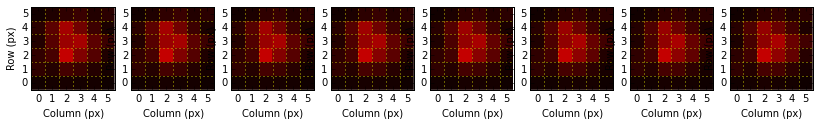

In [30]:
plt.figure(figsize=(14, 5))
start, num = 0, 8
plot_set(guide['imgraws'], start=start, vmax=1500, num=num, grid6x6=True)

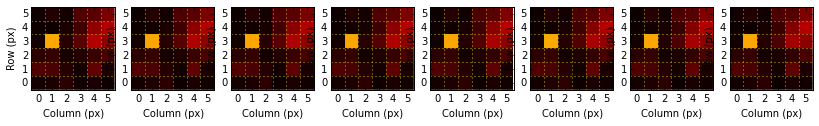

In [31]:
plt.figure(figsize=(14, 5))
start, num = 700, 8
plot_set(guide['imgraws'], start=start, vmax=1500, num=num, grid6x6=True)

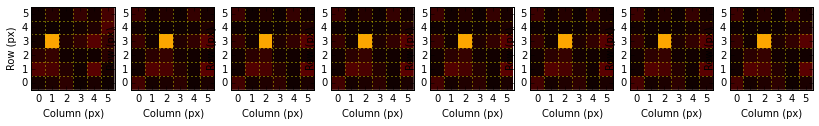

In [37]:
plt.figure(figsize=(14, 5))
start, num = 800, 8
plot_set(guide['imgraws'], start=start, vmax=1500, num=num, grid6x6=True)

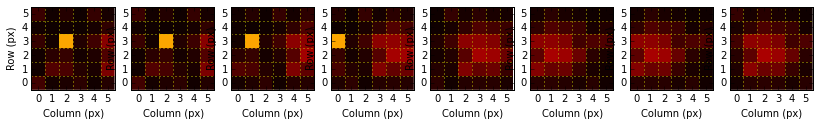

In [44]:
plt.figure(figsize=(14, 5))
start, num = 950, 8
plot_set(guide['imgraws'], start=start, vmax=1500, num=num, grid6x6=True)